In [22]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [23]:
import torch
from torch import nn
from matplotlib import pyplot as plt

# Check PyTorch version
torch.__version__

'2.9.0+cu126'

In [24]:
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step  = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = weight * X + bias

X[:10], Y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [25]:
train_split = int(0.8 * len(X))
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

len(X_train), len(Y_train), len(X_test), len(Y_test)

(40, 40, 10, 10)

In [26]:
def plot_predictions(train_data=X_train,
                     train_labels=Y_train,
                     test_data=X_test,
                     test_labels=Y_test,
                     predictions=None):
    """
    Plota os dados de treino, teste e as previsões do modelo (se houver).
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Dados de Treino")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Dados de Teste")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Previsões")
    
    plt.legend()
    plt.show()
    
def plot_loss_curve(train_loss, test_loss):
    """
    Plota a curva de perda do treino e do teste.
    """
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, c="b", label="Perda de Treino")
    plt.plot(test_loss, c="g", label="Perda de Teste")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss Curves")
    plt.legend()
    plt.show()

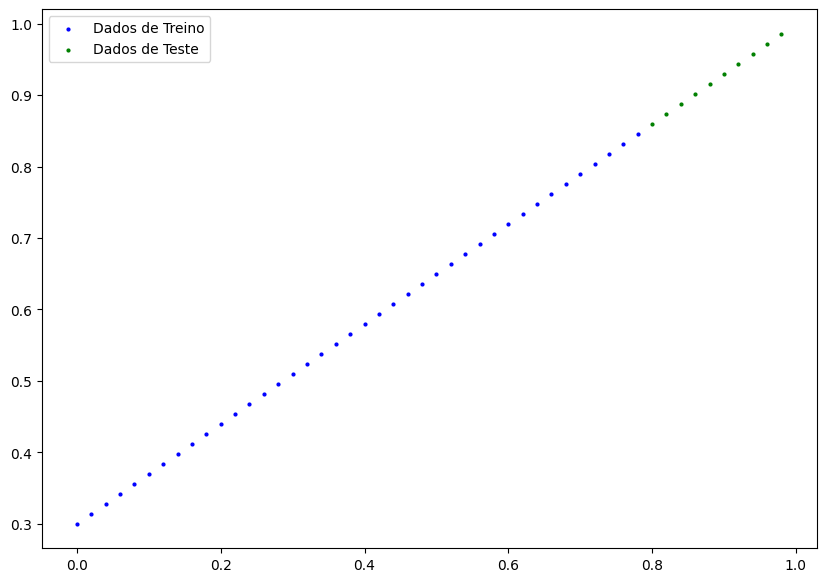

In [27]:
plot_predictions()

In [28]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [29]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [30]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

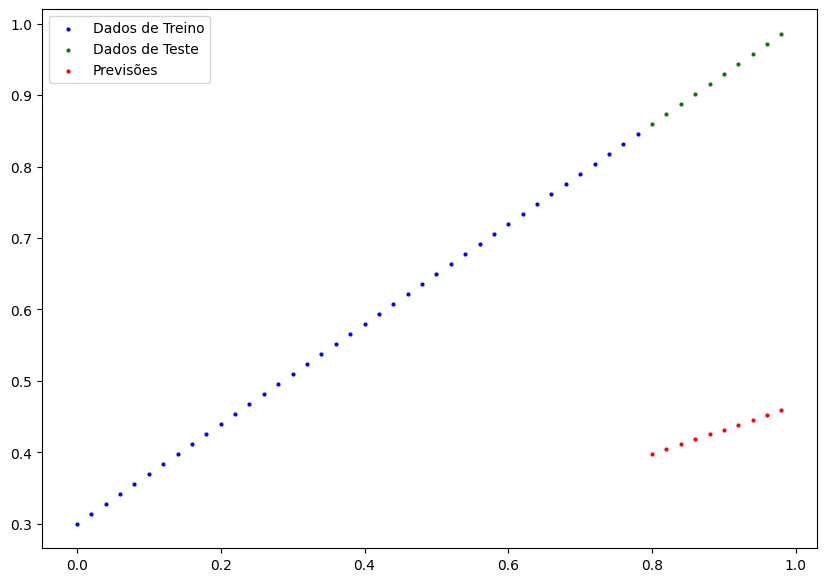

In [31]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds[:10]

plot_predictions(predictions=y_preds)

In [32]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0001)

def training_loop(epochs, model=model_0,
                  loss_fn=loss_fn,
                  optimizer=optimizer, X_train=X_train, Y_train=Y_train,
                  X_test=X_test, Y_test=Y_test):

    epoch_count = []
    train_loss_values = []
    test_loss_values = []


    for epoch in range(epochs):
        # Training mode
        
        # Set the model to training mode changing layers like dropout, batchnorm etc.
        model.train()
        if torch.cuda.is_available():
            model = model.cuda()
            X_train = X_train.cuda()
            Y_train = Y_train.cuda()
            X_test = X_test.cuda()
            Y_test = Y_test.cuda()
        
        # Calculate the model's predictions
        Y_pred = model(X_train)
        
        # Based on the predictions and the ground-truth labels calculate the loss
        loss = loss_fn(Y_pred, Y_train)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        # Testing mode
        
        model.eval()
        
        with torch.inference_mode():
            # 1. Forward pass
            test_pred = model(X_test)
            # 2. Calculate the loss
            test_loss = loss_fn(test_pred, Y_test.type(torch.float))
            # Print out the test loss every 200 epochs
            if epoch % 200 == 0:
                epoch_count.append(epoch)
                train_loss_values.append(loss.item())
                test_loss_values.append(test_loss.item())
                print(f"Epoch: {epoch} | MAE Train Loss: {loss.item():.4f} | MAE Test Loss: {test_loss.item():.4f} | Device: {Y_test.device}")
    
   
    mode = model.cpu()
    return epoch_count, train_loss_values, test_loss_values


Epoch: 0 | MAE Train Loss: 0.0455 | MAE Test Loss: 0.1169 | Device: cuda:0
Epoch: 200 | MAE Train Loss: 0.0446 | MAE Test Loss: 0.1128 | Device: cuda:0
Epoch: 400 | MAE Train Loss: 0.0438 | MAE Test Loss: 0.1093 | Device: cuda:0
Epoch: 600 | MAE Train Loss: 0.0430 | MAE Test Loss: 0.1057 | Device: cuda:0
Epoch: 800 | MAE Train Loss: 0.0423 | MAE Test Loss: 0.1032 | Device: cuda:0


ValueError: x and y must be the same size

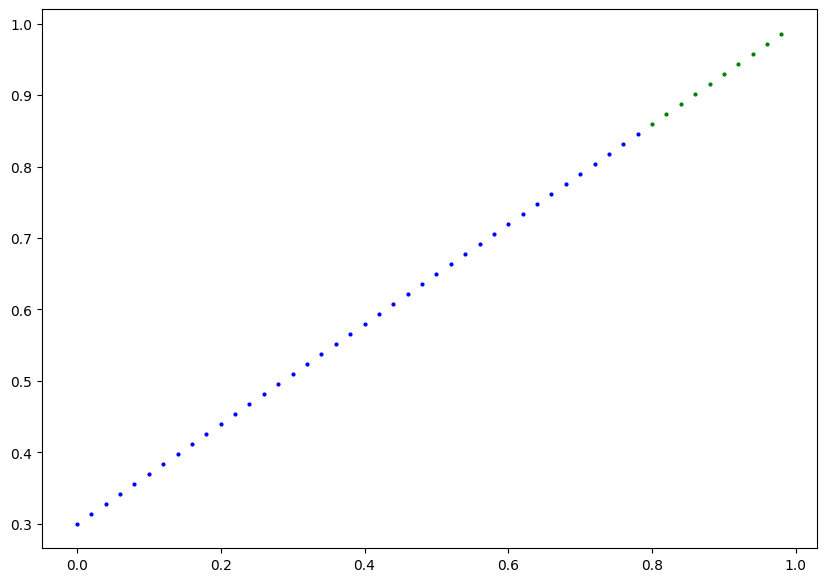

In [45]:
with torch.inference_mode():
    Y_preds = model_0(X_test)

epoch_count_1, train_loss_values_1, test_loss_values_1 = training_loop(epochs=1000, model=model_0, loss_fn=loss_fn, optimizer=optimizer)


plot_predictions(predictions=Y_preds)
plot_loss_curve(train_loss=train_loss_values_1, test_loss=test_loss_values_1)

In [34]:
print(f"Model weights: {model_0.weights.item():.4f}")
print(f"Model bias: {model_0.bias.item():.4f}")
print(f"Original weight: {weight}, Original bias: {bias}")

torch.save(model_0.state_dict(), "linear_regression_model_0.pth")

Model weights: 0.3757
Model bias: 0.2288
Original weight: 0.7, Original bias: 0.3


In [35]:
print("Parameters: ", model_0.state_dict())

Parameters:  OrderedDict({'weights': tensor([0.3757]), 'bias': tensor([0.2288])})


In [36]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load("linear_regression_model_0.pth"))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])

In [37]:
# Create data
import random


start = 0
quantity = 100
X = torch.rand((quantity, 1))
Y = torch.rand((quantity, 1)) * X

X[:10], Y[:10]

(tensor([[0.9408],
         [0.1332],
         [0.9346],
         [0.5936],
         [0.8694],
         [0.5677],
         [0.7411],
         [0.4294],
         [0.8854],
         [0.5739]]),
 tensor([[0.0587],
         [0.0242],
         [0.9344],
         [0.3528],
         [0.5687],
         [0.0191],
         [0.1272],
         [0.1432],
         [0.5120],
         [0.0345]]))

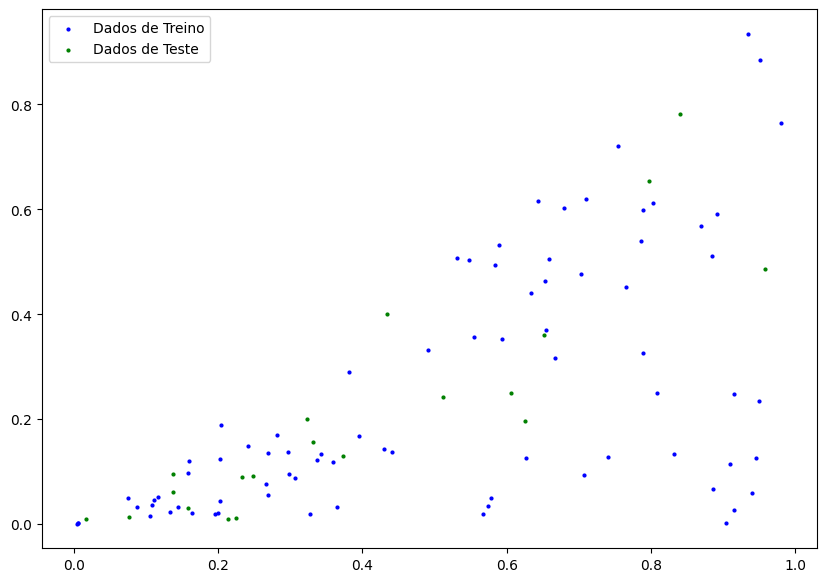

In [38]:
X_train, Y_train = X[:80], Y[:80]
X_test, Y_test = X[80:], Y[80:]
plot_predictions(train_data=X_train,
                 train_labels=Y_train,
                 test_data=X_test,
                 test_labels=Y_test,
                 )



In [39]:
model_1 = LinearRegressionModel()
model_1.state_dict()

optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.000001)
loss_fn_1 = nn.L1Loss()

In [40]:
epoch_count_1, train_loss_values_1, test_loss_values_1 = training_loop(epochs=10, model=model_1, loss_fn=loss_fn_1, optimizer=optimizer_1)

Epoch: 0 | MAE Train Loss: 1.9296 | MAE Test Loss: 2.4895 | Device: cuda:0


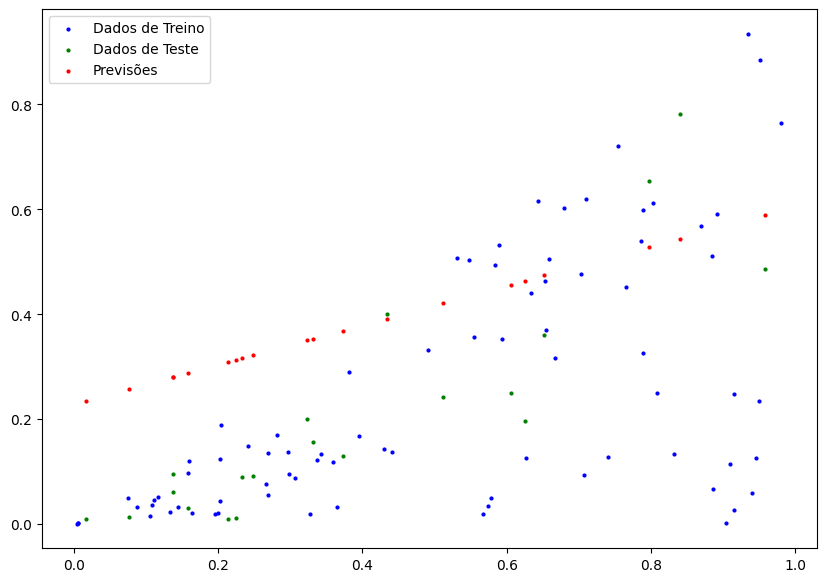

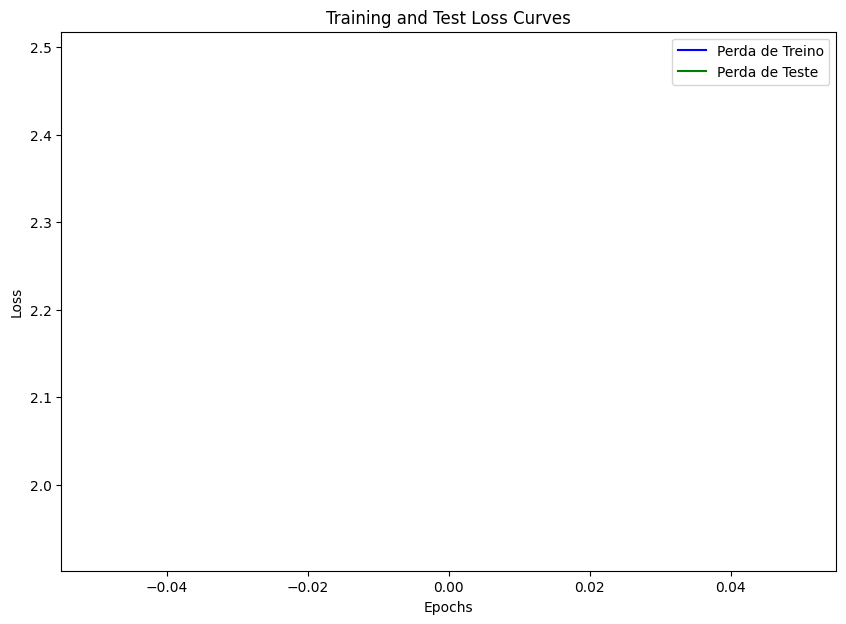

Model 1 weights: -0.4197
Model 1 bias: -1.1929


In [41]:
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    
plot_predictions(train_data=X_train,
                 train_labels=Y_train,
                 test_data=X_test,
                 test_labels=Y_test,
                 predictions=loaded_model_preds
                 )

plot_loss_curve(train_loss=train_loss_values_1, test_loss=test_loss_values_1)
print(f"Model 1 weights: {model_1.weights.item():.4f}")
print(f"Model 1 bias: {model_1.bias.item():.4f}")